# Retrieval-Augmented Generation for Medical Question-Answering

This tutorial demonstrates how to implement retrieval-augmented generation (RAG) to support open-source LLM's -- Google's 2024 gemma 7B-parameter and Meta's 2023 Llama-2 7B-parameter models -- for medical NLP tasks such as QA (question answering). Specifically, it shows how to store documents from the PubMedQA dataset as embeddings vectors in a Chroma database, and retrieve the documents most similar to any query as the context with which to answer the question.

References:

- https://github.com/pubmedqa/pubmedqa
- https://docs.trychroma.com/api-reference
- https://github.com/stephenc222/example-chroma-vector-embeddings"


In [2]:
import settings
# Chroma requires SQLite > 3.35, if you encounter issues with having too 
# low of a SQLite version, try installing pysqlite3-binary, then enter
# the following three lines in settings.py to swap the packages:
#    __import__('pysqlite3')
#    import sys
#    sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import textwrap
import torch
import torch.nn.functional as F
from torch import Tensor
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
import chromadb
from chromadb.utils import embedding_functions 
from chromadb import Documents, EmbeddingFunction, Embeddings
import warnings
warnings.filterwarnings("ignore")

/home/terence/env3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load pubmedqa articles and questions

In [3]:
pqal = pd.read_json('pubmedqa-master/data/ori_pqal.json', orient='index')
print('CONTEXT:', "\n".join(pqal.iloc[0]['CONTEXTS']))
print('QUESTION:', pqal.iloc[0]['QUESTION'])
print('ANSWER:', pqal.iloc[0]['final_decision'])
pqal['final_decision'].value_counts()

CONTEXT: Programmed cell death (PCD) is the regulated death of cells within an organism. The lace plant (Aponogeton madagascariensis) produces perforations in its leaves through PCD. The leaves of the plant consist of a latticework of longitudinal and transverse veins enclosing areoles. PCD occurs in the cells at the center of these areoles and progresses outwards, stopping approximately five cells from the vasculature. The role of mitochondria during PCD has been recognized in animals; however, it has been less studied during PCD in plants.
The following paper elucidates the role of mitochondrial dynamics during developmentally regulated PCD in vivo in A. madagascariensis. A single areole within a window stage leaf (PCD is occurring) was divided into three areas based on the progression of PCD; cells that will not undergo PCD (NPCD), cells in early stages of PCD (EPCD), and cells in late stages of PCD (LPCD). Window stage leaves were stained with the mitochondrial dye MitoTracker Red 

final_decision
yes      552
no       338
maybe    110
Name: count, dtype: int64

## Load chroma client and default embedding model

In [4]:
# Initialize ChromaDB client
db_path = "./database"   # local path to save database
chroma_client = chromadb.PersistentClient(path=db_path)

In [5]:
cprefix = 'pubmedqa_'
for col in chroma_client.list_collections():   # delete old collections
    if col.name.startswith(cprefix):
        chroma_client.delete_collection(col.name)
collections = dict()      # dict for the new collections to create

## Create database collection with default embedding model

In [6]:
# embedding function that embeds any input text
# metadata states how this database should compute similarities (l2 is default)
# default embedding model is all-MiniLM-L6-v2
default_name = "all-MiniLM-L6-v2"
collections[cprefix + default_name] = chroma_client.get_or_create_collection(
    name=f"{cprefix}{default_name}",
    metadata={"hnsw:space": "cosine"}, # l2 is the default
#    embedding_function=embedding_model
)

### Load data into database

In [7]:
# Each document is a context text string
documents = pqal['CONTEXTS'].apply(lambda x: "\n".join(x)).to_list()
np.max([len(doc) for doc in documents])

2725

In [8]:
# Each id is the row number
ids = [str(i) for i in range(len(pqal))]
#metadatas = [{'row': i} for i in ids]

In [9]:
# Load all documents
collections[cprefix + default_name].add(
    documents=documents,
    ids=ids,
)

### Query and retrieve an example

In [10]:
# Each query is a question text string
queries = pqal['QUESTION'].to_list()
gold = 13
result = collections[cprefix + default_name].query(query_texts=queries[gold],
                                                   n_results=1)
print('Gold:', gold, '   Retrieved:', result['ids'])

Gold: 13    Retrieved: [['13']]


## Create collections with alternate embedding models

### Can be any sentence-transformer model
see https://www.sbert.net/docs/pretrained_models.html

In [11]:
# Select other sentence-transformer model by name
other_name = 'NeuML/pubmedbert-base-embeddings'
other_id = other_name.split('/')[-1]
other_model = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name=other_name)

# Create collection with custom embedding function
collections[cprefix + other_id] = chroma_client.get_or_create_collection(
    name=f"{cprefix}{other_id}",
    metadata={"hnsw:space": "cosine"}, # l2 is the default
    embedding_function=other_model,
)

# Add documents
collections[cprefix + other_id].add(
    documents=documents,
    ids=ids,
)

### Or custom embedding function

In [12]:
# select custom embeddings model by name from HF hub
custom_name = 'thenlper/gte-base'
_model = AutoModel.from_pretrained(custom_name)
_tokenizer = AutoTokenizer.from_pretrained(custom_name)
custom_id = custom_name.split('/')[-1]

In [13]:
# inherit from EmbeddingFunction class to implement custom embedding function
class CustomEmbeddingFunction(EmbeddingFunction):
    """Based on https://github.com/stephenc222/example-chroma-vector-embeddings"""

    def __call__(self, texts: Documents) -> Embeddings:
        
        def generate_embeddings(text):
            """Inspired from https://huggingface.co/thenlper/gte-base model card"""

            def average_pool(last_hidden_states: Tensor,
                             attention_mask: Tensor) -> Tensor:
                last_hidden = last_hidden_states.masked_fill(
                    ~attention_mask[..., None].bool(), 0.0)
                return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

            inputs = _tokenizer(
                text,
                return_tensors='pt',
                max_length=512,
                truncation=True,
            )
            with torch.no_grad():
                outputs = _model(**inputs)
            attention_mask = inputs['attention_mask']
            embeddings = average_pool(outputs.last_hidden_state, attention_mask)
            embeddings = F.normalize(embeddings, p=2, dim=1) # Optionally normalize
            return embeddings.numpy().tolist()[0]
    
        return list(map(generate_embeddings, texts))

In [14]:
# Create collection with custom embedding function
custom_model = CustomEmbeddingFunction()
collections[cprefix + custom_id] = chroma_client.get_or_create_collection(
    name=f"{cprefix}{custom_id}",
    metadata={"hnsw:space": "cosine"}, # l2 is the default
    embedding_function=custom_model,
)

In [15]:
# Add documents using custom embeddings
collections[cprefix + custom_id].add(
    documents=documents,
    ids=ids,
)

### Compute retrievel accuracy of the embeddings models

In [16]:
# Check accuracy of id of retrieved document given query
accuracy = {}
for name, collection in collections.items():
    y_pred = []
    for row, query_text in tqdm(enumerate(queries)):
        result = collection.query(query_texts=query_text, n_results=1)
        #print(row, result['ids'][0])
        y_pred.append(int(result['ids'][0][0]))
    accuracy[name] = accuracy_score(y_true=list(range(len(queries))), y_pred=y_pred)
pd.DataFrame.from_dict(accuracy, orient='index', columns=['Accuracy'])

1000it [00:24, 40.08it/s]
1000it [00:30, 32.37it/s]
1000it [00:30, 32.73it/s]


,Accuracy
pubmedqa_all-MiniLM-L6-v2,0.969
pubmedqa_pubmedbert-base-embeddings,0.979
pubmedqa_gte-base,0.988


## t-SNE plot of embeddings

True pairs of documents and queries are observed to group closely together in 2D embeddings space.

In [17]:
# Generate embeddings for documents and queries
embeddings = [[], []]
max_tsne = len(documents)
for i in tqdm(range(max_tsne)):
    embeddings[0].extend(custom_model([documents[i]]))
for i in tqdm(range(max_tsne)):
    embeddings[1].extend(custom_model([queries[i]]))

100%|██████████| 1000/1000 [00:28<00:00, 34.85it/s]


In [18]:
def tsne_plot(documents, queries):
    "Creates and TSNE model and plots it"
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2,
                      init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(np.array(documents + queries))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 10))
    for i in range(len(x)):
        is_query = int(i / len(documents))
        plt.scatter(x[i], y[i], color=f"C{is_query}")
        plt.annotate(str(i % len(documents)),
                     xy=(x[i], y[i]),
                     xytext=(5, 2) if is_query else (-5, -2),
                     color=f"C{is_query}",
                     textcoords='offset points',
                     ha='right' if is_query else "left",
                     va='bottom' if is_query else "top")
    plt.title('t-SNE plot of embeddings of documents and queries')
    #plt.show()

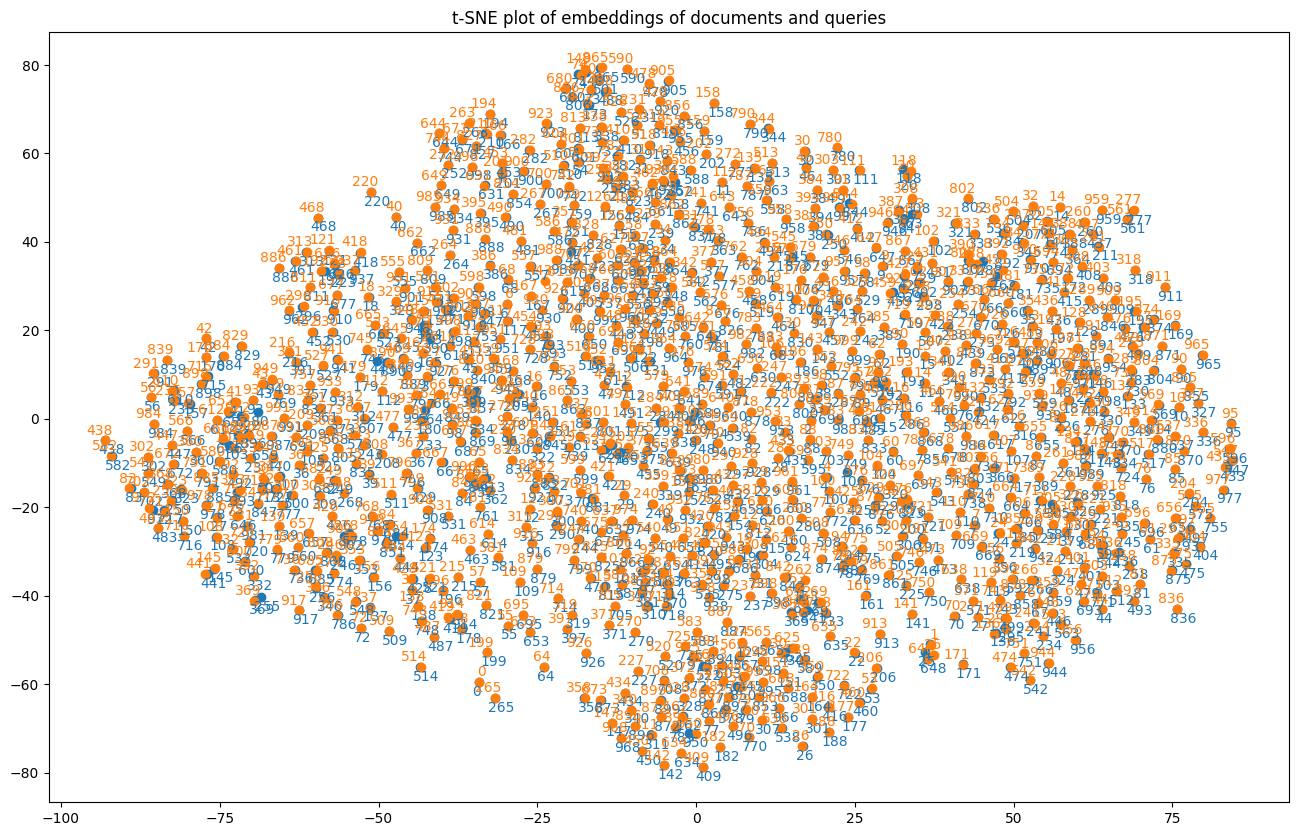

In [19]:
# tsne-plot of documents and queries, in two different colors, in 2D space
tsne_plot(embeddings[0], embeddings[1])

In [19]:
# View sample embedding vectors
from sentence_transformers.util import cos_sim
example = 42
sentences = [documents[example]]
custom_embeddings = custom_model(sentences)
other_embeddings = other_model(sentences)
print(cos_sim(other_embeddings[0], custom_embeddings[0]))

tensor([[-0.0158]])


In [20]:
print('Custom embedding:', custom_name, '\n', np.round(custom_embeddings, 4))

Custom embedding: thenlper/gte-base 
 [[-3.300e-02 -1.820e-02 -1.890e-02 -7.320e-02  6.990e-02  2.530e-02
   5.660e-02  1.590e-02 -3.380e-02 -4.950e-02  1.050e-02  1.090e-02
  -3.080e-02  2.960e-02 -3.140e-02  9.750e-02  4.360e-02  2.440e-02
   3.600e-02  1.620e-02  2.290e-02 -5.680e-02  7.400e-03  2.930e-02
   1.100e-03 -4.820e-02  3.960e-02  3.570e-02 -6.770e-02  4.300e-03
   5.590e-02 -4.730e-02  4.000e-03 -6.810e-02  4.890e-02  1.110e-02
   1.230e-02  2.370e-02 -1.840e-02 -6.430e-02 -6.180e-02 -2.400e-03
  -4.290e-02  6.100e-03 -4.820e-02 -4.400e-03 -2.720e-02  2.350e-02
   3.000e-04  8.700e-03 -8.690e-02 -1.950e-02 -5.200e-03 -2.300e-03
   2.000e-03  4.720e-02  9.000e-03 -4.700e-03 -1.110e-02 -7.830e-02
   3.340e-02  2.190e-02  4.380e-02 -4.550e-02  1.600e-02  2.470e-02
  -8.000e-04  1.920e-02 -5.580e-02 -1.030e-02  2.800e-03  2.520e-02
   1.030e-02 -3.140e-02  2.800e-03 -4.240e-02 -9.600e-03 -2.520e-02
   3.980e-02  9.000e-03  3.200e-03  3.300e-02 -1.430e-02  6.910e-02
   5.700e-

In [21]:
print('Other embedding:', other_name, '\n', np.round(other_embeddings, 4))

Other embedding: NeuML/pubmedbert-base-embeddings 
 [[ 4.1550e-01  1.9460e-01  7.2040e-01 -2.3700e-02 -5.7920e-01  4.3200e-01
   3.7090e-01 -5.8380e-01  2.1830e-01  3.1450e-01 -6.7880e-01  3.7070e-01
   4.7700e-02  2.7790e-01  3.6290e-01  1.6510e-01  3.8680e-01 -7.4990e-01
  -1.5590e-01 -7.2150e-01 -3.6300e-01 -1.3800e-01  1.0400e-01  6.1200e-01
  -5.7300e-02  1.3920e-01 -3.9240e-01  1.1250e-01 -5.8400e-02 -1.1068e+00
  -5.5580e-01 -8.8530e-01  4.5600e-01 -9.7450e-01  3.8300e-01  6.5600e-01
   4.1870e-01 -3.5930e-01 -6.2110e-01 -1.8610e-01 -4.3670e-01 -4.6800e-02
  -4.6960e-01 -1.1697e+00  3.9950e-01  6.2570e-01 -6.0870e-01  3.2460e-01
   4.3210e-01  2.1790e-01 -5.1810e-01 -2.6200e-02  1.4490e-01  5.4740e-01
   7.8160e-01 -1.6350e-01  4.3840e-01 -6.5400e-02  1.3766e+00  4.9160e-01
  -1.6140e-01 -8.0700e-02  1.3840e-01  2.2150e-01  1.5770e-01  1.0532e+00
  -2.2730e-01 -1.5665e+00 -2.9120e-01 -4.8190e-01 -5.2830e-01  9.7700e-02
  -8.0310e-01  1.4450e-01 -1.1526e+00  6.2390e-01 -1.0000e-0

## Helpers to prepare prompt and generate chat

In [22]:
import gc
def empty_cache(verbose=False):
    """helper attempts to reclaim memory"""
    if verbose:
        print(f"CUDA allocated before: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    for _ in range(100):
        with torch.no_grad():
            torch.cuda.empty_cache()
    gc.collect()
    if verbose:
        print(f"CUDA allocated after: {torch.cuda.memory_allocated()/1e9:.2f} GB")

### To generate response

In [23]:
DEFAULT_ROLE = "You are a helpful AI assistant."
DEFAULT_ROLE = "You are a helpful medical knowledge assistant."
MAX_NEW_TOKENS = 8
TEMPERATURE = None

In [24]:
def chat(prompt, role,  model, tokenizer, max_new_tokens=MAX_NEW_TOKENS,
         verbose=False, skip_special_tokens=True):
    """Prompt the model and return response"""

    # always prepend with a system prompt
    input_ids = tokenizer(f"{role}\n{prompt}\n".strip(),
                          return_tensors="pt").to("cuda")
    input_len = len(input_ids[0])
    with torch.no_grad():
        outputs = model.generate(**input_ids,
                                 max_new_tokens=max_new_tokens,
                                 top_p=None,
                                 do_sample=bool(TEMPERATURE),
                                 temperature=TEMPERATURE,
        )
    if verbose:
        print('Input tokens:', input_len,
              '  Output tokens:', len(outputs[0]))
    answer = tokenizer.decode(outputs[0][input_len:],
                              skip_special_tokens=skip_special_tokens)
    del [input_ids, outputs]  # reclaim memory
    empty_cache()
    return answer.lower()

In [25]:
def get_answer(answer, verbose=False):
    """helper to label answer as 'yes' or 'maybe' or 'no'""" 
    answer = answer.lower()
    for label in ['yes', 'maybe', 'no']:
        if label in answer:
            return label
    if verbose:
        print(answer)
    return 'maybe'

In [26]:
# list of true answers
y_true = [get_answer(pqal.iloc[i]['final_decision']) for i in range(len(pqal))]

### To create prompt

Llama and Gemme require slightly different prompt instructions.


In [27]:
def prepare_prompt_gemma(question, context):
    """Create prompt for gemma model"""
    
    if context:   # with context
        return f"""
Use the following text to return an answer to the question.
Return a concise answer to the question in 1 word.

Text:
{context}

Question:
{question}

Answer:
        """.strip()
    else:         # without context
        return f"""
Return a concise answer to the question in 1 word.

Question:
{question}

Answer:
        """.strip()

In [28]:
def prepare_prompt_llama(question, context=''):
    """Create prompt for llama model"""
    
    if context:    # with context
        return f"""
Use the following text to return a concise answer to the question at the end.

Text:
{context}

Question:
{question}

Answer:
        """.strip()
    else:         # without context
        return f"""
Question:
{question}

Answer:
        """.strip()

In [29]:
def prepare_prompt(question, context, model_name):
    """Create prompt given model name"""
    if 'gemma' in model_name:
        return prepare_prompt_gemma(question, context)
    else:
        return prepare_prompt_llama(question, context)

## Evaluate models

Compare LLM's as well as context-retrieval models (i.e. word embeddings models)

In [30]:
# Compare these models for QA accuracy
model_names = ["google/gemma-7b-it", "meta-llama/Llama-2-7b-chat-hf"]

# Compare these methods for retrieving context
choices = [c.name for c in chroma_client.list_collections()]   # by querying RAG collections
choices += ['with-gold', 'no-context']                         # or with- or without true context

accuracy = {}   # to store accuracy scores

In [31]:
for model_name in model_names:
    accuracy[model_name] = {}
    
    # Load and quantize model
    compute_dtype = getattr(torch, "float16")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=False,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        quantization_config=bnb_config, 
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:  # Fix missing pad_token error
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))
    model.config.use_cache = False
    model.config.pretraining_tp = 1

    # Example of a prompt and response
    row = 13
    question, context, gold = queries[row], documents[row], y_true[row]
    print(f"Model={model_name}.  Example #{row} with gold:", {gold})
    role = ""

    # without context
    prompt = prepare_prompt(question, context="", model_name=model_name)
    print('NO CONTEXT:')
    print(chat(prompt, role=role, model=model, tokenizer=tokenizer, verbose=True))
    print('-----------------------------------')

    # with context
    print('WITH CONTEXT:')
    prompt = prepare_prompt(question, context=context, model_name=model_name)
    print(chat(prompt, role=role, model=model, tokenizer=tokenizer, verbose=True))
    print('-----------------------------------')

    # Evaluate context choices
    for choice in choices:  # loop over each context choice
        y_pred = []
        for i in tqdm(range(len(queries))):   # loop over pubmed examples

            # The prompt for this example depends on context choice
            question = queries[i]
            match choice:
                case 'no-context':  # no context
                    context = ""
                case 'with-gold':   # true context
                    context = documents[i]
                case _:             # with retrieved context 
                    context = collections[choice].query(
                        query_texts=question, n_results=1
                    )['documents'][0][0]
            prompt = prepare_prompt(
                question, context=context, model_name=model_name
            )

            # Generate answer
            answer = " ".join(chat(prompt,role, model, tokenizer).split())
            # print(i, y_true[i], '-', answer)
            y_pred.append(get_answer(answer))

        # Compute classification report
        accuracy[model_name][choice] = accuracy_score(y_true=y_true, y_pred=y_pred)
        class_report = classification_report(y_true=y_true, y_pred=y_pred, digits=3)
        print(f'\nClassification Report (context={choice}, model={model_name}:')
        print(class_report)

    del model
    empty_cache(verbose=True)
    print()

Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Model=google/gemma-7b-it.  Example #13 with gold: {'no'}
NO CONTEXT:
Input tokens: 40   Output tokens: 43

yes
-----------------------------------
WITH CONTEXT:
Input tokens: 367   Output tokens: 375

no

the text does not describe
-----------------------------------


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]



Classification Report (context=pubmedqa_all-MiniLM-L6-v2, model=google/gemma-7b-it:
              precision    recall  f1-score   support

       maybe      0.065     0.018     0.028       110
          no      0.587     0.846     0.693       338
         yes      0.797     0.696     0.743       552

    accuracy                          0.672      1000
   macro avg      0.483     0.520     0.488      1000
weighted avg      0.645     0.672     0.647      1000



100%|██████████| 1000/1000 [09:51<00:00,  1.69it/s]



Classification Report (context=pubmedqa_pubmedbert-base-embeddings, model=google/gemma-7b-it:
              precision    recall  f1-score   support

       maybe      0.069     0.018     0.029       110
          no      0.591     0.846     0.696       338
         yes      0.797     0.703     0.747       552

    accuracy                          0.676      1000
   macro avg      0.486     0.522     0.491      1000
weighted avg      0.647     0.676     0.651      1000



100%|██████████| 1000/1000 [09:56<00:00,  1.68it/s]



Classification Report (context=pubmedqa_gte-base, model=google/gemma-7b-it:
              precision    recall  f1-score   support

       maybe      0.067     0.018     0.029       110
          no      0.594     0.843     0.697       338
         yes      0.798     0.708     0.750       552

    accuracy                          0.678      1000
   macro avg      0.486     0.523     0.492      1000
weighted avg      0.648     0.678     0.653      1000



100%|██████████| 1000/1000 [09:17<00:00,  1.79it/s]



Classification Report (context=with-gold, model=google/gemma-7b-it:
              precision    recall  f1-score   support

       maybe      0.067     0.018     0.029       110
          no      0.596     0.846     0.699       338
         yes      0.798     0.708     0.750       552

    accuracy                          0.679      1000
   macro avg      0.487     0.524     0.493      1000
weighted avg      0.649     0.679     0.654      1000



100%|██████████| 1000/1000 [05:31<00:00,  3.01it/s]



Classification Report (context=no-context, model=google/gemma-7b-it:
              precision    recall  f1-score   support

       maybe      0.167     0.036     0.060       110
          no      0.463     0.408     0.434       338
         yes      0.603     0.741     0.665       552

    accuracy                          0.551      1000
   macro avg      0.411     0.395     0.386      1000
weighted avg      0.508     0.551     0.520      1000

CUDA allocated before: 6.02 GB
CUDA allocated after: 0.01 GB



Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]


Model=meta-llama/Llama-2-7b-chat-hf.  Example #13 with gold: {'no'}
NO CONTEXT:
Input tokens: 34   Output tokens: 42


introduction:

primary care
-----------------------------------
WITH CONTEXT:
Input tokens: 416   Output tokens: 424

no, the study found that autom
-----------------------------------


100%|██████████| 1000/1000 [10:04<00:00,  1.65it/s]



Classification Report (context=pubmedqa_all-MiniLM-L6-v2, model=meta-llama/Llama-2-7b-chat-hf:
              precision    recall  f1-score   support

       maybe      0.175     0.227     0.198       110
          no      0.667     0.675     0.671       338
         yes      0.775     0.723     0.748       552

    accuracy                          0.652      1000
   macro avg      0.539     0.542     0.539      1000
weighted avg      0.672     0.652     0.661      1000



100%|██████████| 1000/1000 [10:15<00:00,  1.63it/s]



Classification Report (context=pubmedqa_pubmedbert-base-embeddings, model=meta-llama/Llama-2-7b-chat-hf:
              precision    recall  f1-score   support

       maybe      0.182     0.236     0.206       110
          no      0.680     0.678     0.679       338
         yes      0.775     0.730     0.752       552

    accuracy                          0.658      1000
   macro avg      0.545     0.548     0.545      1000
weighted avg      0.677     0.658     0.667      1000



100%|██████████| 1000/1000 [10:28<00:00,  1.59it/s]



Classification Report (context=pubmedqa_gte-base, model=meta-llama/Llama-2-7b-chat-hf:
              precision    recall  f1-score   support

       maybe      0.181     0.236     0.205       110
          no      0.688     0.672     0.680       338
         yes      0.776     0.739     0.757       552

    accuracy                          0.661      1000
   macro avg      0.548     0.549     0.547      1000
weighted avg      0.681     0.661     0.670      1000



100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]



Classification Report (context=with-gold, model=meta-llama/Llama-2-7b-chat-hf:
              precision    recall  f1-score   support

       maybe      0.181     0.236     0.205       110
          no      0.688     0.672     0.680       338
         yes      0.776     0.739     0.757       552

    accuracy                          0.661      1000
   macro avg      0.548     0.549     0.547      1000
weighted avg      0.681     0.661     0.670      1000



100%|██████████| 1000/1000 [07:23<00:00,  2.26it/s]


Classification Report (context=no-context, model=meta-llama/Llama-2-7b-chat-hf:
              precision    recall  f1-score   support

       maybe      0.099     0.464     0.163       110
          no      0.397     0.080     0.133       338
         yes      0.571     0.431     0.491       552

    accuracy                          0.316      1000
   macro avg      0.356     0.325     0.262      1000
weighted avg      0.460     0.316     0.334      1000

CUDA allocated before: 4.30 GB
CUDA allocated after: 0.01 GB



In [32]:
# Summary of accuracy scores
pd.DataFrame(accuracy)

,google/gemma-7b-it,meta-llama/Llama-2-7b-chat-hf
pubmedqa_all-MiniLM-L6-v2,0.672,0.652
pubmedqa_pubmedbert-base-embeddings,0.676,0.658
pubmedqa_gte-base,0.678,0.661
with-gold,0.679,0.661
no-context,0.551,0.316
